In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#import all of the models I plan on using
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


#import all of the metrics to evaluate each of my models
from sklearn.metrics import accuracy_score, fbeta_score, roc_curve, roc_auc_score, make_scorer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Import supplementary visualization code visuals.py
import visuals as vs

In [2]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [3]:
def plot_roc(name, clf, ytest, xtest):
    roc_auc = roc_auc_score(ytest, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(ytest, clf.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='ROC curve for %s (area = %0.3f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    return fpr, tpr

## Data Preprocessing

Let's start out reading in the data file into a Pandas Dataframe. 

In [5]:
data_cumulative = pd.io.stata.read_stata('anes_timeseries_cdf_stata12.dta')

I did some research and found that variable that represents party preference is VCF0301.  I ended up grouping leaning towards the Republican party as being Republican, and did the same for Democrats.  Since this is going to be our target variable, I eliminated the Independents from the data set, as this will be a binary classification problem. I also got rid of people that refused to answer. 

In [6]:
#get rid of independents
data_party_preferred = data_cumulative[data_cumulative.VCF0301 != '4. Independent - Independent']

#get rid of IDK's/NA/Refused to Answer
data_party_preferred = data_party_preferred[data_party_preferred.VCF0301 \
                                            != '0. DK; NA; other; refused to answer; no Pre IW']

Looking at the top of our data, it is clear that the missing data needs to be eliminated since it is abundant.  Most of this was performed manually, where I went though the variable descriptions attached to the dataset and got first got rid of anything not pertinent. 

In [7]:
data_party_preferred.VCF0301.head()

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
Name: VCF0301, dtype: category
Categories (8, object): [0. DK; NA; other; refused to answer; no Pre IW < 1. Strong Democrat < 2. Weak Democrat < 3. Independent - Democrat < 4. Independent - Independent < 5. Independent - Republican < 6. Weak Republican < 7. Strong Republican]

Quick note, the following features were found doing the following steps:
1. I went through the variable information and kept anything I found relevant. 
2. I deleted any variables that were not in both 1952-1960 and 2004-2012 since I plan on doing a comparative analysis between these time frames.  

Rename features so my data is more interpretable and easier to work with.

In [8]:
features = ['VCF0004','VCF0102', 'VCF0104', 'VCF0106', \
            'VCF0110', 'VCF0112', 'VCF0113', 'VCF0114',\
           'VCF0118', 'VCF0127', 'VCF0128',\
           'VCF0143', 'VCF0147', 'VCF0301']
cleaned_data = data_party_preferred[features]
cleaned_data = cleaned_data[(cleaned_data.VCF0004 >= 1952) & (cleaned_data.VCF0004 <= 2012)]
cleaned_data.columns = ['year', 'age_range','gender', 'race_3', 'education_level', 'geo_region', 'south', \
                'hh_income_percentile', 'occupation', 'union_membership', 'religion', 'parents_native_born', \
                'marital_status','party_preference']

#deleted redundant vars with more NAs
#       'VCF0105a' -> race7
#        'VCF0151' -> occupation_several

In [9]:
cleaned_data.religion.value_counts()

1. Protestant                                           29369
2. Catholic [Roman Catholic]                            11164
4. Other and none (also includes DK preference)          5553
3. Jewish                                                1157
0. DK; NA; refused to answer; no Pre IW; no Post IW;      368
Name: religion, dtype: int64

Using the value_counts( ) function, find the values for each variable that I do not want and can eliminate from the data set (e.g. IDK, did not respond, etc.)

I may have cleaned up the data too much.  If I am not satisfied with the accuracy of my model, I may come back up here and remove features and add samples back to my training set. 

In [10]:
cleaned_data = cleaned_data[cleaned_data.age_range != '0. NA; DK; RF; no Pre IW']
#cleaned_data = cleaned_data[cleaned_data.race_7 != '9. Missing']
cleaned_data = cleaned_data[cleaned_data.race_3 != '0. Missing, pre-1966 data']
cleaned_data= cleaned_data[cleaned_data.race_3 != '9. Missing, DK/REF/NA']
cleaned_data = cleaned_data[cleaned_data.education_level != "0. DK; NA; no Pre IW; short-form 'new' Cross Section"]
cleaned_data = cleaned_data[cleaned_data.hh_income_percentile != '0. DK; NA; refused to answer; no Pre IW']
cleaned_data = cleaned_data[cleaned_data.occupation != '9. DK; NA; no Pre IW']
cleaned_data = cleaned_data[cleaned_data.religion != '0. DK; NA; refused to answer; no Pre IW; no Post IW;']
cleaned_data = cleaned_data[cleaned_data.union_membership != "0. DK; NA; no Pre IW; short-form 'new' Cross"]
cleaned_data = cleaned_data[cleaned_data.parents_native_born != "9. NA; RF; no Pre IW; short-form 'new' Cross Section"]
cleaned_data = cleaned_data[cleaned_data.parents_native_born != "8. DK"]
cleaned_data = cleaned_data[cleaned_data.marital_status != "9.  NA; no Pre IW; unmarried at time of IW (1952 only); short-form 'new' Cross-Section (1992)"]
cleaned_data = cleaned_data[cleaned_data.marital_status != "8. R not married/partnered, refused to say whether never married, divorced, separated or widowed (1992 only); DK"]
#cleaned_data = cleaned_data[cleaned_data.occupation_several != "0. NA; member of armed forces; no occupation and not a"]

#get rid of unsused categories
cleaned_data.party_preference = cleaned_data.party_preference.cat.remove_unused_categories()
cleaned_data.gender = cleaned_data.gender.cat.remove_unused_categories()
cleaned_data.age_range = cleaned_data.age_range.cat.remove_unused_categories()
#cleaned_data.race_7 = cleaned_data.race_7.cat.remove_unused_categories()
cleaned_data.race_3 = cleaned_data.race_3.cat.remove_unused_categories()
cleaned_data.education_level = cleaned_data.education_level.cat.remove_unused_categories()
cleaned_data.hh_income_percentile= cleaned_data.hh_income_percentile.cat.remove_unused_categories()
cleaned_data.occupation = cleaned_data.occupation.cat.remove_unused_categories()
cleaned_data.religion = cleaned_data.religion.cat.remove_unused_categories()
cleaned_data.union_membership = cleaned_data.union_membership.cat.remove_unused_categories()
cleaned_data.parents_native_born = cleaned_data.parents_native_born.cat.remove_unused_categories()
cleaned_data.marital_status = cleaned_data.marital_status.cat.remove_unused_categories()
#cleaned_data.occupation_fewer = cleaned_data.occupation_several.cat.remove_unused_categories()

#rename categories for cleaner plots
cleaned_data.gender = cleaned_data.gender.cat.rename_categories(['Male', 'Female'])
cleaned_data.party_preference = cleaned_data.party_preference.cat.rename_categories(['Strong Democrat', 'Weak Democrat', 'Leans Democrat', 'Leans Republican', 'Weak Republican', 'Strong Republican'])
cleaned_data.geo_region = cleaned_data.geo_region.cat.rename_categories(['Northeast', 'North Central', 'South', 'West'])
cleaned_data.south = cleaned_data.south.cat.rename_categories(['South', 'Nonsouth'])
cleaned_data.hh_income_percentile = cleaned_data.hh_income_percentile.cat.rename_categories(['0-16 Percentile', '17-33 Percentile', '34-67 Percentile', '68-95 Percentile', '96-100 Percentile'])

In [11]:
sum(cleaned_data.party_preference == 'Strong Democrat') + \
sum(cleaned_data.party_preference == 'Weak Democrat') + \
sum(cleaned_data.party_preference == 'Leans Democrat')

25508

In [11]:
25508./len(cleaned_data.party_preference)

0.5977130002811885

In [17]:
#only include data from the 2004, 2008, and 2012 surveys
modern_data = cleaned_data[(cleaned_data.year >= 2004) & (cleaned_data.year <= 2012)]
modern_data.index = range(modern_data.index.size)

In [18]:
print "Strong Dem: " , sum(modern_data.party_preference == 'Strong Democrat')
print "Weak Dem: " ,sum(modern_data.party_preference == 'Weak Democrat')
print "Leans Dem: " ,sum(modern_data.party_preference == 'Leans Democrat')
print "Strong Rep: " ,sum(modern_data.party_preference == 'Strong Republican')
print "Weak Rep: " ,sum(modern_data.party_preference == 'Weak Republican')
print "Leans Rep: " ,sum(modern_data.party_preference == 'Leans Republican')


Strong Dem:  2094
Weak Dem:  1311
Leans Dem:  1220
Strong Rep:  1086
Weak Rep:  922
Leans Rep:  873


In [13]:
modern_data['Party'] = ((modern_data.party_preference == "Strong Democrat") | \
(modern_data.party_preference == "Weak Democrat") | \
(modern_data.party_preference == "Leans Democrat")) * 1

In [14]:
modern_data.head()

,year,age_range,gender,race_3,education_level,geo_region,south,hh_income_percentile,occupation,union_membership,religion,parents_native_born,marital_status,party_preference,Party
0,2004.0,4. 45 - 54,Male,3. Other,3. Some college (13 grades or more but no degree;,West,Nonsouth,68-95 Percentile,1. Employed,"2. No, no one in household belongs to a labor ...",1. Protestant,5. No,3. Divorced,Leans Democrat,1
1,2004.0,3. 35 - 44,Female,1. White non-Hispanic,4. College or advanced degree (no cases 1948),South,South,96-100 Percentile,4. Homemaker (since 1972: not working 20 or mo...,"2. No, no one in household belongs to a labor ...",1. Protestant,1. Yes,1. Married,Strong Republican,0
2,2004.0,5. 55 - 64,Female,1. White non-Hispanic,"2. High school (12 grades or fewer, incl. non-...",South,South,17-33 Percentile,1. Employed,"2. No, no one in household belongs to a labor ...",1. Protestant,1. Yes,3. Divorced,Strong Republican,0
3,2004.0,4. 45 - 54,Female,1. White non-Hispanic,4. College or advanced degree (no cases 1948),West,Nonsouth,34-67 Percentile,1. Employed,"2. No, no one in household belongs to a labor ...",2. Catholic [Roman Catholic],1. Yes,5. Widowed,Strong Republican,0
4,2004.0,5. 55 - 64,Female,1. White non-Hispanic,3. Some college (13 grades or more but no degree;,North Central,Nonsouth,0-16 Percentile,1. Employed,"2. No, no one in household belongs to a labor ...",1. Protestant,1. Yes,3. Divorced,Weak Democrat,1


In [15]:
float(modern_data.Party.sum())/len(modern_data.Party) #60/40 split- relatively balanced dataset

0.6161737276845191

## Data Exploration Phase

Let's build a color palette for pretty visualizations, representative of the extent to which someone considers themselves a Democrat or Republican, on a 1-6 Scale (Strong Dem, Weak Dem, Leans Dem, Leans Rep, Weak Rep, Strong Rep).

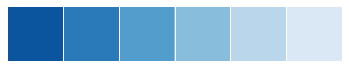

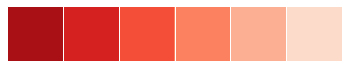

In [16]:
#color palette's I am interested in for my visualizations
sns.palplot(sns.color_palette("Blues_r"))
sns.palplot(sns.color_palette("Reds_r"))

In [17]:
print "Red color palette raw values: \n", sns.color_palette("Reds_r")
print "\n Blue color palette raw values: \n", sns.color_palette("Blues_r")

Red color palette raw values: 
[(0.66634371395617076, 0.063391003460207609, 0.08641291810841982), (0.83704728950403684, 0.13394848135332565, 0.13079584775086506), (0.95700115340253744, 0.30871203383314111, 0.22191464821222606), (0.98658977316416763, 0.50672818146866594, 0.38123798539023457), (0.9882352941176471, 0.68667435601691651, 0.57788542868127646), (0.99506343713956169, 0.85965397923875431, 0.79866205305651672)]

 Blue color palette raw values: 
[(0.044059976931949255, 0.33388696655132638, 0.62445213379469444), (0.16696655132641294, 0.48069204152249134, 0.72915032679738567), (0.32628988850442142, 0.61862360630526725, 0.80279892349096504), (0.53568627450980388, 0.74608227604767396, 0.8642522106881968), (0.73094963475586316, 0.83947712418300646, 0.92132256824298342), (0.85840830449826988, 0.91344867358708182, 0.9645674740484429)]


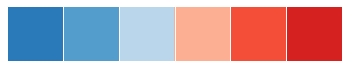

In [18]:
customized_pal = [(0.16696655132641294, 0.48069204152249134, 0.72915032679738567),
 (0.32628988850442142, 0.61862360630526725, 0.80279892349096504),
 (0.73094963475586316, 0.83947712418300646, 0.92132256824298342), 
  (0.9882352941176471, 0.68667435601691651, 0.57788542868127646),
 (0.95700115340253744, 0.30871203383314111, 0.22191464821222606),
(0.83704728950403684, 0.13394848135332565, 0.13079584775086506)]
#beautiful
sns.palplot(customized_pal)

Now that we have a color palette to differentiate amongnst the training samples, let's explore some of the features in the data set.  

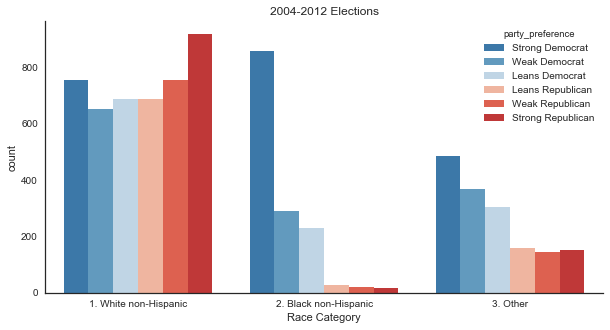

In [19]:
sns.set_style("white")
plt.figure(figsize=(10,5))
sns.countplot(x="race_3", hue="party_preference", data=modern_data,\
              palette=customized_pal)
plt.xlabel('Race Category')
plt.title('2004-2012 Elections')
remove_border()

Race clearly has a strong effect on party identification.  It looks like White non-Hispanic people are predominantly Republican (especially considering there is a 60/40 split of Dems to Reps in this data set). On the other hand, black people overwhelmingly identify as Democrats (like by A LOT).  

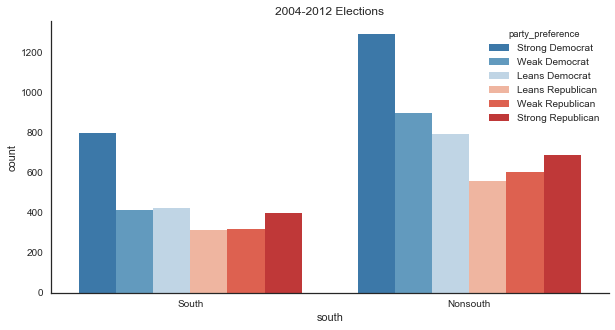

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(x="south", hue="party_preference", data=modern_data,\
              palette=customized_pal)
plt.title('2004-2012 Elections')
remove_border()

To my surprise, the south has more Democrats than Republicans.  This partly derives from the fact that Democrats are oversampled in this poll. 

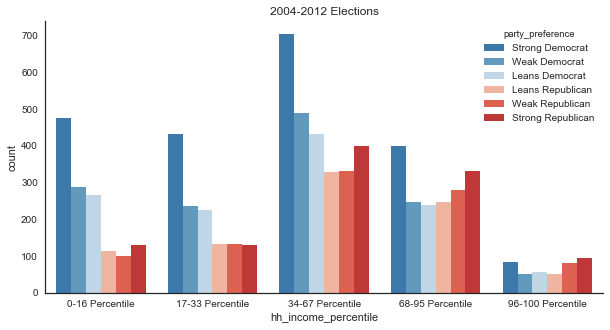

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(x="hh_income_percentile", hue="party_preference", data=modern_data,\
              palette=customized_pal)
plt.title('2004-2012 Elections')
remove_border()

Household income also looks to have a strong impact on party preference.  Lower and middle class people are much more likely to be Democrat whereas the richest percentiles see a stronger presence from Republicans. 

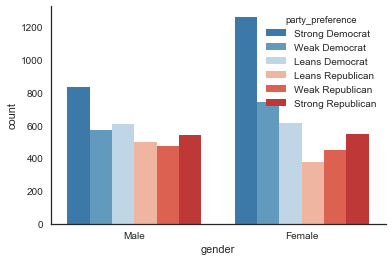

In [22]:
sns.countplot(x="gender", hue="party_preference", data=modern_data,\
              palette=customized_pal)
remove_border()

Gender also seems to play a role, as women are much more likely to be Democrat rather than Republican, whereas men have a relatively even split among the parties. Let's visualize this in another way, because I am getting tired of bar charts.  Point plot, maybe?

In [23]:
#very tedious way of making a point plot...
#was having trouble in seaborn and pandas so I did it all manually instead

male_party = []
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Strong Democrat")))
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Weak Democrat")))
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Leans Democrat")))
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Leans Republican")))
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Weak Republican")))
male_party.append(sum((modern_data.gender == "Male") & \
    (modern_data.party_preference == "Strong Republican")))

female_party = []
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Strong Democrat")))
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Weak Democrat")))
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Leans Democrat")))
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Leans Republican")))
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Weak Republican")))
female_party.append(sum((modern_data.gender == "Female") & \
    (modern_data.party_preference == "Strong Republican")))

count = female_party + male_party

parties = ["Strong Democrat", "Weak Democrat", "Leans Democrat", \
           "Leans Republican", "Weak Republican", "Strong Republican",\
          "Strong Democrat", "Weak Democrat", "Leans Democrat", \
           "Leans Republican", "Weak Republican", "Strong Republican"]
genders = ['Female'] * 6 + ['Male']*6

df = pd.DataFrame({'gender': genders, 'political preference': parties, \
                  'Count': count})

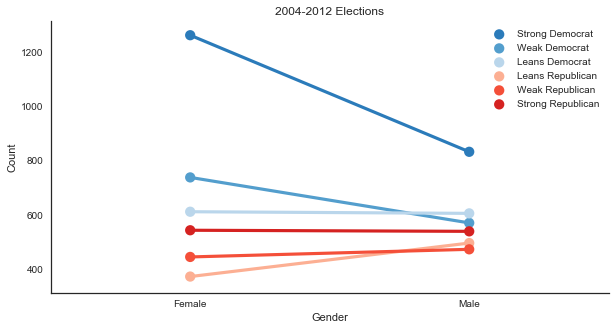

In [24]:
plt.figure(figsize=(10,5))
sns.pointplot(x = "gender", y = "Count", hue = "political preference", \
              data = df, palette=customized_pal)

plt.legend(loc='upper right')
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('2004-2012 Elections')
remove_border()

Takeaway from this plot: Huge decrease in strong Democrat affilation going from female to male, with modest decreases among weak Democrats and leaning Democrat.  On the other hand, all affiliations of Republicans see modest increases across the board going from female to male.

## Machine Learning on Modern Data

Let's only focus on the modern data now to make some predictions.  I am going to include the data for the 2004, 2008, and 2012 elections.

In [25]:
modern_data = cleaned_data[(cleaned_data.year >= 2004) & (cleaned_data.year <= 2012)]
modern_data.index = range(modern_data.index.size)
modern_data = modern_data.drop(['year'], axis=1)

Separate the data into its target variable and its features.  

In [26]:
party_modern = modern_data['party_preference']
features_modern = modern_data.drop('party_preference', axis = 1)


In [27]:
#one hot encoding for our features since they are all discrete
features_modern_final =  pd.get_dummies(features_modern)


In [28]:
features_modern_final.head()

,age_range_1. 17 - 24,age_range_2. 25 - 34,age_range_3. 35 - 44,age_range_4. 45 - 54,age_range_5. 55 - 64,age_range_6. 65 - 74,age_range_7. 75 - 99 and over (except 1954),gender_Male,gender_Female,race_3_1. White non-Hispanic,race_3_2. Black non-Hispanic,race_3_3. Other,education_level_1. Grade school or less (0-8 grades),"education_level_2. High school (12 grades or fewer, incl. non-college",education_level_3. Some college (13 grades or more but no degree;,education_level_4. College or advanced degree (no cases 1948),geo_region_Northeast,geo_region_North Central,geo_region_South,geo_region_West,south_South,south_Nonsouth,hh_income_percentile_0-16 Percentile,hh_income_percentile_17-33 Percentile,hh_income_percentile_34-67 Percentile,hh_income_percentile_68-95 Percentile,hh_income_percentile_96-100 Percentile,occupation_1. Employed,"occupation_2. Not employed: laid off, unemployed, on strike,",occupation_3. Retired,occupation_4. Homemaker (since 1972: not working 20 or more hrs/wk;,occupation_5. Student (since 1972: not working 20 or more hrs/wk;,"union_membership_1. Yes, someone (1948: head) in household belongs to a","union_membership_2. No, no one in household belongs to a labor union",religion_1. Protestant,religion_2. Catholic [Roman Catholic],religion_3. Jewish,religion_4. Other and none (also includes DK preference),parents_native_born_1. Yes,parents_native_born_5. No,marital_status_1. Married,marital_status_2. Never married,marital_status_3. Divorced,marital_status_4. Separated,marital_status_5. Widowed,"marital_status_7. Partners; not married (VOLUNTEERED [exc.1986,2012])"
0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0


We need to convert our party preferential categories into a binary category.  This is done by encoding "Democrat" as 1 and "Republican" as 0. 

In [29]:
convert_to_binary = ((party_modern == "Strong Democrat") | \
(party_modern == "Weak Democrat") | \
(party_modern == "Leans Democrat")) * 1

In [30]:
combined_party_encoding= pd.concat([party_modern, convert_to_binary], axis=1)
combined_party_encoding.columns = ['Category', 'Binary']
party_modern_final = combined_party_encoding['Binary']

In [31]:
import warnings
warnings.filterwarnings('ignore')

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_modern_final, 
                                                    party_modern_final, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 6004 samples.
Testing set has 1502 samples.


Let's start by assessing the score og a logisitic regression classifier, one of the more basic algorithms often used for binary classification problems. Since there is some imbalance in my classes (60-40 Dem-Rep split), I thought it would be wise to also generate a Receiver Operating Characteristic in order to better visualize the predictive capabilities of my classifier. 

Accuracy: 0.721


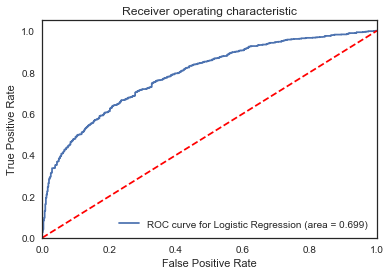

In [32]:
from sklearn.linear_model import LogisticRegression

logreg_1 = LogisticRegression()
logreg_1.fit(X_train, y_train)
predictions = logreg_1.predict(X_test)
score = logreg_1.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_logreg_1, tpr_logreg_1 = plot_roc("Logistic Regression", logreg_1, y_test, X_test)


Not a bad testing accuracy for a baseline classifier, but I think I can squeeze a little more out of it.  My testing set is ~6000 samples currently, but this could be higher if reduce the redundant inputs in my feature space.  I will get rid of the race input with seven categories and one of the occupation classes. 

My reasoning is this: I filter out all NA values, which will reduce my data set size with each feature I add. 

Accuracy: 0.721


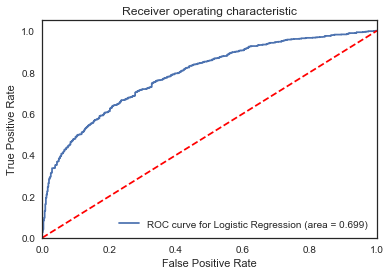

In [33]:
logreg_2 = LogisticRegression()
logreg_2.fit(X_train, y_train)
predictions = logreg_2.predict(X_test)
score = logreg_2.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_logreg_2, tpr_logreg_2 = plot_roc("Logistic Regression", logreg_2, y_test, X_test)


Cleaning up the feature set was certainly helpful.  We went from a 69.2 accuracy to 72.6 and our ROC curve area increased from 0.67 to 0.70. 

Now, before I attempt different algorithms to squeeze the most performance out of my model as possible, I am going to try and build additional features from my data set to see if that can improve my model a little bit.  




## Feature Importance

Now that we have stripped out dataset to be more digestible, we can start investigating into the feature importance.  I will first do this using the recursive method for logistic regression, in which the most important feature is found, then dropped for the next iteration of the algorithm, continuously until the most prevalent features are accounted for.  

In [34]:
from sklearn.feature_selection import RFE
model = LogisticRegression()
# Let's find the top attribute
rfe = RFE(model, 1)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
[38 30 31 32 29 44 34 46  8  2  1 18  6 13 25 39 40 27 26 37 45 10 11 23 24
 33  9 22 20 21 12 43  5 35  7 41  3 42 17 16  4 28 36 15 19 14]


In [35]:
features_with_rank = []
for i in range(1, len(features_modern_final.columns) + 1):
    features_with_rank.append(str(rfe.ranking_[i-1]) + '. ' + features_modern_final.columns[i -1])

#print features_with_rank

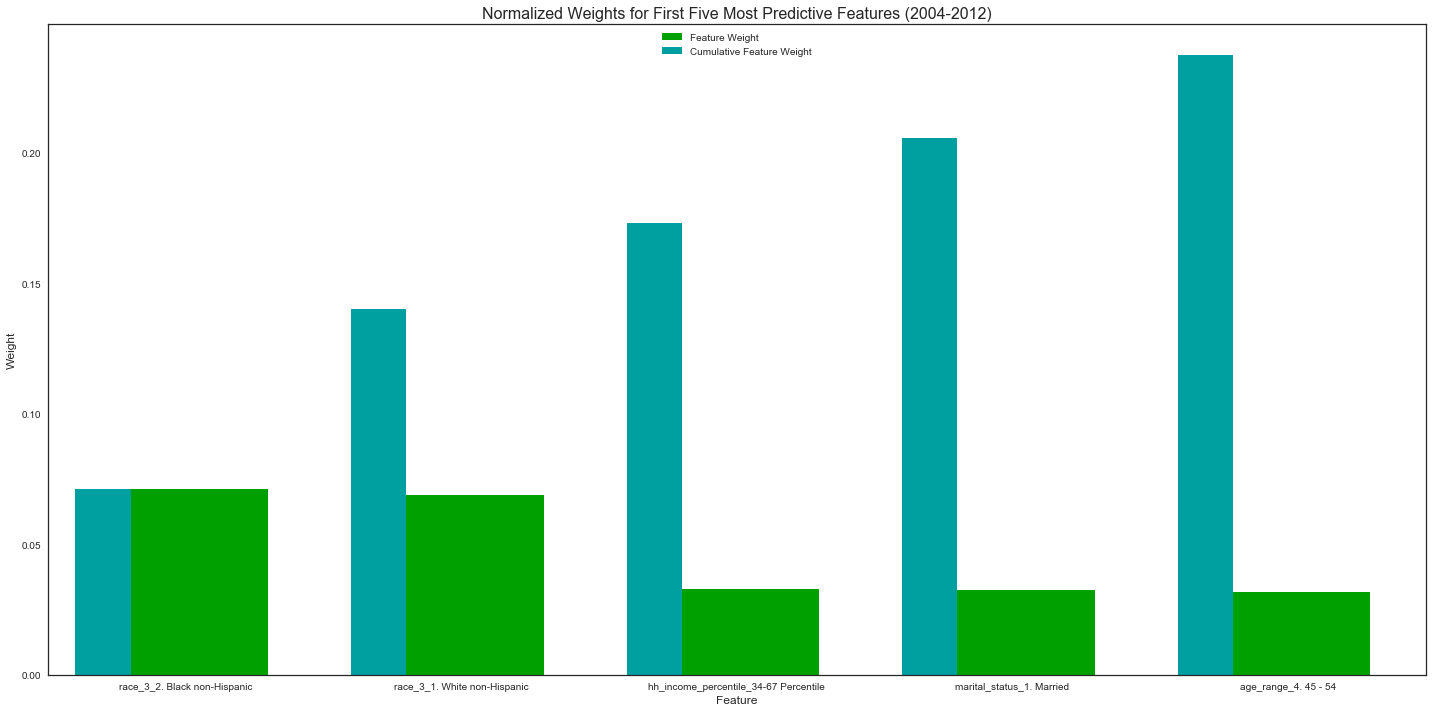

In [49]:
# Import a supervised learning model that has 'feature_importances_'

from sklearn.ensemble import RandomForestClassifier
# Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]
fig = plt.figure(figsize = (20,10))
plt.title("Normalized Weights for First Five Most Predictive Features (2004-2012)", fontsize = 16)
plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
plt.xticks(np.arange(5), columns)
plt.xlim((-0.5, 4.5))
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Feature", fontsize = 12)
    
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()  

It looks like black is the most important feature for both logistic regression and the random forest classifier.  Marital status is also very important in both.

## Model Comparison

Let's look into the performance of several models to see which ones we should further investigate. We will first do a comparison based on the accuracies of each of the model outputs.  

In [37]:
#Benchmark Model
naive_predictions = np.ones(len(y_test))
print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, naive_predictions)))
print("Final F-score on the testing data: {:.4f}\n"\
          .format(fbeta_score(y_test, naive_predictions, beta = 0.5)))

Final accuracy score on the testing data: 0.6378
Final F-score on the testing data: 0.6876



Accuracy: 0.644


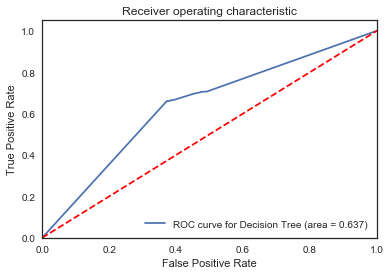

In [38]:

d_tree = DecisionTreeClassifier()
d_tree.fit(X_train, y_train)
predictions = d_tree.predict(X_test)
score = d_tree.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_d_tree, tpr_d_tree = plot_roc("Decision Tree", d_tree, y_test, X_test)


Accuracy: 0.670


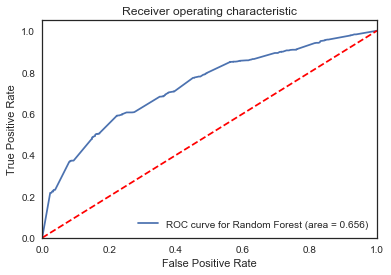

In [39]:
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
predictions = RF.predict(X_test)
score = RF.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_RF, tpr_RF = plot_roc("Random Forest", RF, y_test, X_test)


Accuracy: 0.719


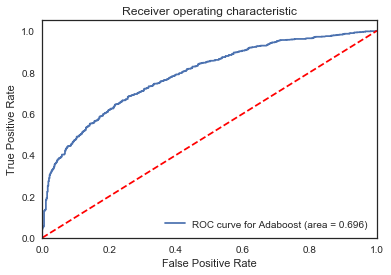

In [40]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)
score = adaboost.score(X_test, y_test)
print ("Accuracy: %.3f" %(score))
fpr_ada, tpr_ada = plot_roc("Adaboost", adaboost, y_test, X_test)


In [41]:
from xgboost import XGBClassifier

clf = AdaBoostClassifier()
clf.fit(X_train.values, y_train.values)
predictions = clf.predict(X_test.values)
score = clf.score(X_test.values, y_test.values)
print ("Accuracy: %.3f" %(score))
print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, predictions)))
print("Final F-score on the testing data: {:.4f}"\
      .format(fbeta_score(y_test, predictions, beta = 0.5)))

Accuracy: 0.719
Final accuracy score on the testing data: 0.7190
Final F-score on the testing data: 0.7795


Log Reg: Accuracy: 0.702870 Std: (0.011987)
CART: Accuracy: 0.617086 Std: (0.010313)
Random Forest: Accuracy: 0.654067 Std: (0.010277)
AdaBoost: Accuracy: 0.702705 Std: (0.012944)
SVM: Accuracy: 0.706201 Std: (0.011411)


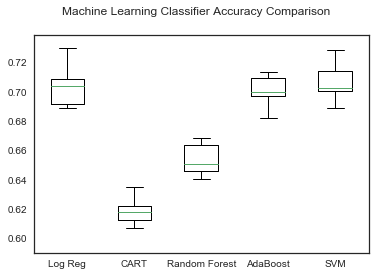

In [42]:
# prepare models for comparative analysis
models = []
models.append(('Log Reg', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
seed = 0
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    output = "%s: Accuracy: %f Std: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning Classifier Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Let's do the same thing as above, except this time let's look into the F1 Score's since our dataset has some class imbalance within it. 

Log Reg: F1 Score: 0.760803 Std: (0.011791)
CART: F1 Score: 0.678059 Std: (0.011466)
Random Forest: F1 Score: 0.722708 Std: (0.009985)
AdaBoost: F1 Score: 0.759723 Std: (0.012702)
SVM: F1 Score: 0.757401 Std: (0.011258)


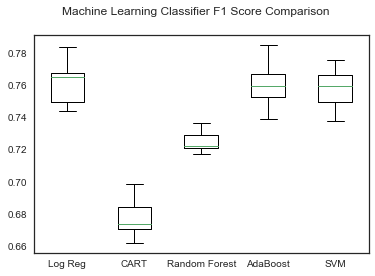

In [43]:
# prepare models for comparative analysis
models = []
models.append(('Log Reg', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('SVM', SVC()))

# evaluate each model in turn
seed = 0
results = []
names = []
scoring = 'f1'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    output = "%s: F1 Score: %f Std: (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning Classifier F1 Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hyperparameter Tuning 

It looks like the highest performance models from both an F score and accuracy standpoint are logistic regression, AdaBoost, and SVM.  Let's do some optimizations to see if we can improve our model even more. 

In [45]:
#the four models I want to tune
logistic = LogisticRegression()
adaboost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
svm = SVC(kernel = 'rbf')

models = [logistic, adaboost, grad_boost, svm]
best_estimators = []
for model in models:
    if model == logistic:
        hyperparameters = dict(C=np.logspace(0,4,10), penalty=['l1', 'l2'])
    elif model == adaboost:
        hyperparameters = {'n_estimators':range(80,201,10)}
    elif model == grad_boost:
        hyperparameters = {'n_estimators':range(10,81,10),
                           'max_depth':range(1,10,2)}
    else: #model is SVM
        hyperparameters = {'C': #[ 0.1, 1, 10, 100]
                           [10,100,1000],'gamma': [0.001, 0.01, 0.1, 1]}
        
    grid = GridSearchCV(model, hyperparameters, cv=5, verbose=0)  
    grid_fit = grid.fit(X_train, y_train)
    best_estimators.append(grid_fit.best_estimator_)
    
        
print best_estimators    

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=90, random_state=None), GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False), SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=No

It looks like the logistic regression is already optimized since these parameters are already the default values.  

In [48]:
logistic = LogisticRegression()
adaboost = AdaBoostClassifier(n_estimators= 100)
grad_boost = GradientBoostingClassifier(n_estimators = 30, max_depth = 5)
svm = SVC(kernel = 'rbf', C = 100, gamma = 0.01)


optimized_models = [logistic, adaboost, grad_boost, svm]

for model in optimized_models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    print"Model: %s\n" %str(model)
    print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, predictions)))
    print("Final F-score on the testing data: {:.4f}\n"\
          .format(fbeta_score(y_test, predictions, beta = 0.5)))
    

Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Final accuracy score on the testing data: 0.7210
Final F-score on the testing data: 0.7817

Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

Final accuracy score on the testing data: 0.7184
Final F-score on the testing data: 0.7791

Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=30, presort='auto', random_state=None,
              subsample=1.0, 